In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Analyze swivel scores

## DEPRECATED

In [100]:
from collections import namedtuple, defaultdict
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm import tqdm

from nama.data.filesystem import download_file_from_s3
from nama.data.utils import read_csv
from nama.models.swivel import SwivelModel, get_best_swivel_matches


In [3]:
# config

# TODO run both given and surname
given_surname = "given"
# given_surname = "surname"

vocab_size = 610000 if given_surname == "given" else 2100000
embed_dim = 100
Config = namedtuple("Config", [
    "std_path",
    "frequencies_path",
    "embed_dim",
    "swivel_vocab_path",
    "swivel_model_path",
])
config = Config(
    std_path = f"../references/std_{given_surname}.txt",
    frequencies_path = f"s3://fs-nama-data/2024/familysearch-names/interim/tree-hr-{given_surname}-aggr-v2.parquet",
    embed_dim=embed_dim,
    swivel_vocab_path=f"s3://fs-nama-data/2024/nama-data/data/models/fs-{given_surname}-swivel-vocab-{vocab_size}-augmented.csv",
    swivel_model_path=f"s3://fs-nama-data/2024/nama-data/data/models/fs-{given_surname}-swivel-model-{vocab_size}-{embed_dim}-augmented.pth",
    
)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print("cuda total", torch.cuda.get_device_properties(0).total_memory)
    print("cuda reserved", torch.cuda.memory_reserved(0))
    print("cuda allocated", torch.cuda.memory_allocated(0))

cuda:0
True
cuda total 8141471744
cuda reserved 0
cuda allocated 0


In [5]:
# load buckets
bucket_names = defaultdict(set)
name_buckets = defaultdict(set)
with open(config.std_path, 'rt') as f:
    for line in f.readlines():
        names = line.strip().replace(':', ' ').split(' ')
        bucket_name = names[0]
        for name in names:
            name = name.strip()
            if len(name) == 0:
                continue
            bucket_names[bucket_name].add(name)
            name_buckets[name].add(bucket_name)
print(len(bucket_names), len(name_buckets))

8878 95997


## Analyze counts

In [6]:
# load counts
frequencies_path = download_file_from_s3(config.frequencies_path) if config.frequencies_path.startswith("s3://") else config.frequencies_path
counts_df = pd.read_parquet(frequencies_path)
print(counts_df.shape)
counts_df.head(3)

(25541154, 10)


,name,alt_name,frequency,reverse_frequency,sum_name_frequency,total_name_frequency,total_alt_name_frequency,ordered_prob,unordered_prob,similarity
0,a,a,1622927,1622927,2578937,36295683,36295683,0.629301,4.680698e-02,1.000000
1,a,aa,154,139,2578937,36295683,5067,0.000060,8.071524e-06,0.500000
2,a,aaa,3,5,2578937,36295683,143,0.000001,2.204111e-07,0.333333


In [7]:
# create a dataframe with alt name frequencies
counts_df = counts_df[['alt_name', 'total_alt_name_frequency']].drop_duplicates()
print(counts_df.shape)
counts_df.head(3)

(6148634, 2)


,alt_name,total_alt_name_frequency
0,a,36295683
1,aa,5067
2,aaa,143


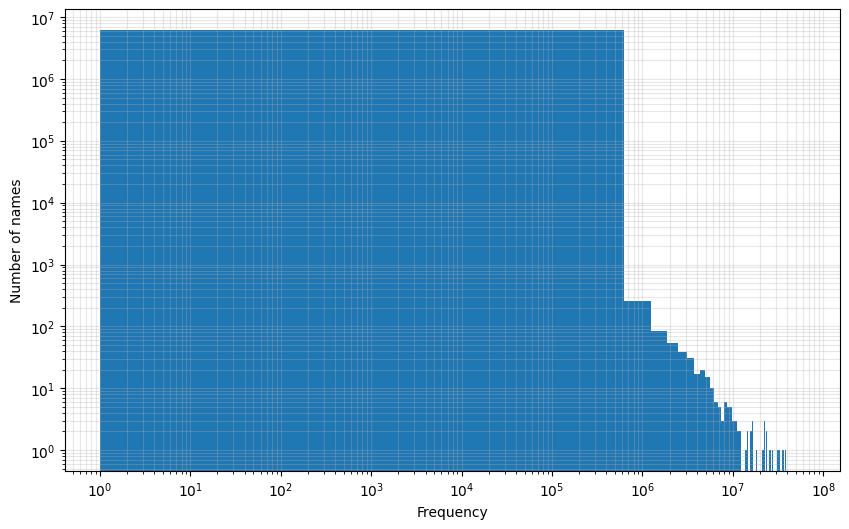

In [14]:
counts_df['total_alt_name_frequency'].plot(kind='hist', bins=100, figsize=(10, 6), 
                                           logy=True, grid=True)
plt.xscale('log')
plt.xlabel('Frequency')
plt.ylabel('Number of names')
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [40]:
# create a dictionary with alt name frequencies
name_frequency = dict(zip(counts_df['alt_name'], counts_df['total_alt_name_frequency']))

In [33]:
# create a dictionary with frequencies for all names in the buckets
# set a max frequency of 10,000
max_freq = 10000
high_freq_names = 0
bucket_name_frequency = {}
for ix, name in enumerate(name_buckets):
    freq = name_frequency.get(name, 0)
    if freq > max_freq:
        freq = max_freq
        high_freq_names += 1
    bucket_name_frequency[name] = freq
    if ix % 1000 == 0:
        print(name, freq)
print(len(bucket_name_frequency))
print(high_freq_names)

aa 5067
addeline 7562
alpert 375
alizabet 20
mandee 234
engelef 23
antien 744
aresta 394
asser 1686
eayres 39
barthli 1164
bamma 4333
byrns 1003
bogomil 27
bradner 3138
calfernia 526
casel 1007
cataina 163
chile 255
satina 673
clemans 1794
conrod 6350
chrisostomus 4122
darrus 227
daynes 270
detleff 1665
darthulia 1722
edmvnd 46
elenterio 10000
elmes 905
remmet 137
estebania 8583
ewa 10000
faolan 0
florece 1342
freidel 137
gehard 4279
joergen 6291
gervass 102
gulda 464
gaudalupe 1766
hall 10000
heyne 194
henriika 178
ilura 234
huberti 10000
ingermarie 555
isidio 1395
jenna 10000
juel 10000
josafat 829
caren 9773
lobelia 1099
lessing 702
lindel 3651
lelina 941
lorien 1398
lucintha 1156
magon 146
manen 296
margat 2644
martisia 299
maton 767
melany 786
micijah 99
modesto 10000
nabba 169
nl 117
neina 450
olymphia 646
othela 1437
pasion 1446
parmellia 242
phillippy 42
prisillah 71
randyl 92
rhinaldo 537
rmi 6
rosaura 10000
ruurt 422
zorie 418
semjon 10
shurah 42
sytie 57
stand 393
zuzana 780

/tmp/ipykernel_891094/1150228902.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


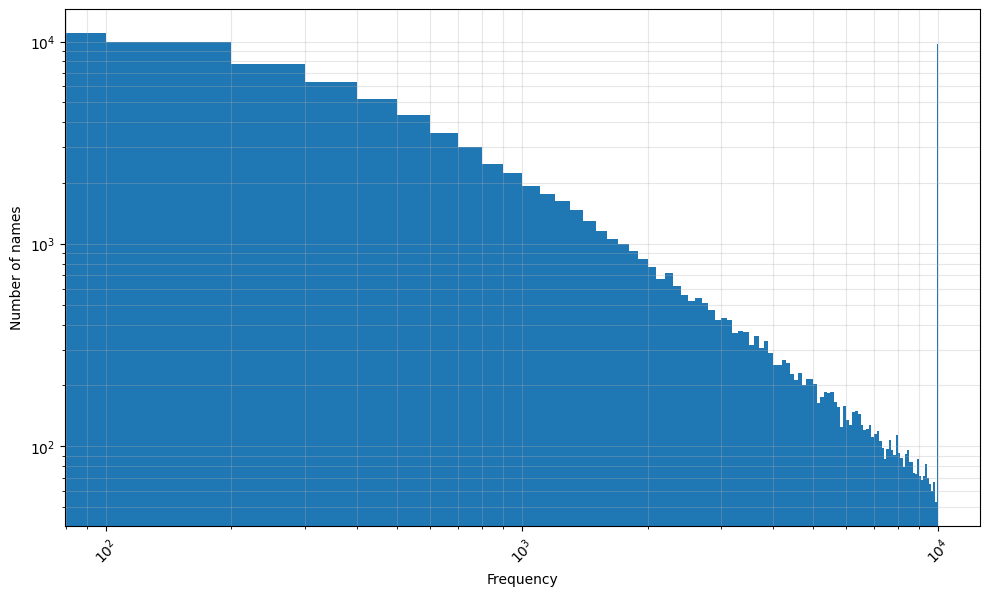

In [34]:
# turn it into a dataframe and plot it
bucket_name_counts_df = pd.DataFrame(list(bucket_name_frequency.items()), columns=['name', 'frequency'])
bucket_name_counts_df['frequency'].plot(kind='hist', bins=100, figsize=(10, 6), 
                                        logy=True, grid=True)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
# Add grid for better readability
plt.grid(True, alpha=0.3)
# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.xscale('log')
plt.xlabel('Frequency')
plt.ylabel('Number of names')
plt.grid(True, which="both", alpha=0.3)
plt.show()

## Load swivel

In [35]:
# load swivel vocab
swivel_vocab_path = download_file_from_s3(config.swivel_vocab_path) if config.swivel_vocab_path.startswith("s3://") else config.swivel_vocab_path
vocab_df = read_csv(swivel_vocab_path)
swivel_vocab = {name: _id for name, _id in zip(vocab_df["name"], vocab_df["index"])}
print(len(swivel_vocab))

610000


In [36]:
swivel_model_path = download_file_from_s3(config.swivel_model_path) if config.swivel_model_path.startswith("s3://") else config.swivel_model_path
swivel_model = SwivelModel(len(swivel_vocab), config.embed_dim)
swivel_model.load_state_dict(torch.load(swivel_model_path, map_location=torch.device(device)))
swivel_model.to(device)
swivel_model.eval()

/tmp/ipykernel_891094/3076184165.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  swivel_model.load_state_dict(torch.load(swivel_model_path, map_location=torch.device(dev

SwivelModel(
  (wi): Embedding(610000, 100)
  (wj): Embedding(610000, 100)
  (bi): Embedding(610000, 1)
  (bj): Embedding(610000, 1)
)

## Calculate swivel scores for names in the same bucket

In [45]:
max_freq = 10000
frequency_scores = []
for bucket_name, names in tqdm(bucket_names.items()):
    if bucket_name not in swivel_vocab:
        # print("bucket name missing", bucket_name)
        continue
    bucket_name_frequency = name_frequency.get(bucket_name, 0)
    for name in names:
        if name not in swivel_vocab:
            # print("name missing", name)
            continue
        if name == bucket_name:
            continue
        name_freq = name_frequency.get(name, 0)
        swivel_scores = get_best_swivel_matches(model=swivel_model, 
                                                vocab=swivel_vocab, 
                                                input_names=np.array([bucket_name]),
                                                candidate_names=np.array([name]), 
                                                encoder_model=None,
                                                k=1, 
                                                batch_size=1000,
                                                add_context=True,
                                                progress_bar=False,
                                                n_jobs=1)
        score = swivel_scores[0][0][1] if len(swivel_scores) > 0 else 0
        # get the minimum frequency of the bucket name, the name
        # and set the upper-bound of the frequency to max_freq so we can plot it and see low-frequency names better
        min_name_frequency = min(bucket_name_frequency, name_freq, max_freq)
        frequency_scores.append((min_name_frequency, score))

100%|██████████| 8878/8878 [01:21<00:00, 109.32it/s]


In [46]:
def plot_3d_histogram(freq_score_pairs, freq_bins=10, score_bins=10):
    """
    Create a 3D histogram of scores grouped by frequency
    
    Parameters:
    freq_score_pairs: list of tuples (frequency, score)
    freq_bins: number of frequency bins
    score_bins: number of score bins
    """
    # Convert to numpy arrays
    frequencies, scores = zip(*freq_score_pairs)
    frequencies = np.array(frequencies)
    scores = np.array(scores)
    
    # Create the histogram
    hist, xedges, yedges = np.histogram2d(frequencies, scores, bins=(freq_bins, score_bins))
    
    # Get the mesh grid
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0
    
    # Get the heights
    dx = (xedges[1] - xedges[0]) * 0.8
    dy = (yedges[1] - yedges[0]) * 0.8
    dz = hist.ravel()
    
    # Create the 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the bars
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', 
             alpha=0.8, cmap='viridis')
    
    # Labels
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Score')
    ax.set_zlabel('Count')
    ax.set_title('3D Histogram of Scores by Frequency')
    
    plt.show()

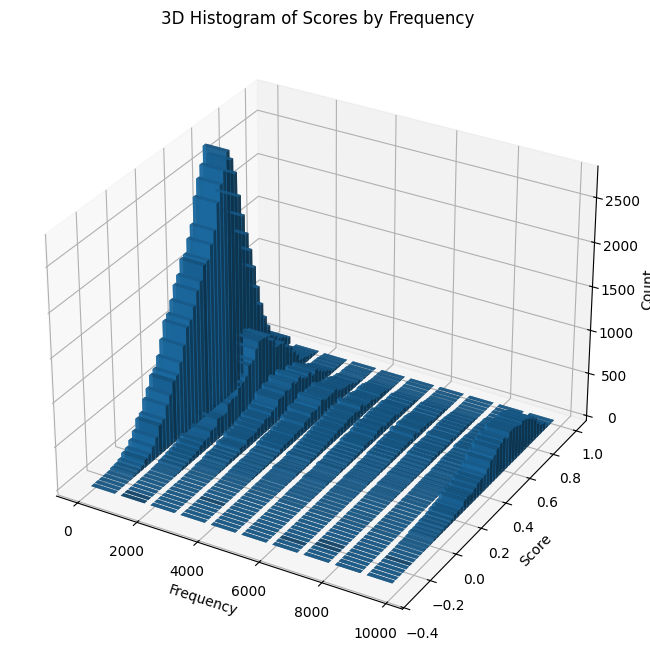

In [47]:
plot_3d_histogram(frequency_scores, freq_bins=10, score_bins=50)

In [51]:
def plot_score_distributions(freq_score_pairs, num_freq_buckets=5, max_freq=None):
    """
    Create side-by-side score distributions for different frequency ranges
    """
    # Convert to numpy arrays
    frequencies, scores = zip(*freq_score_pairs)
    frequencies = np.array(frequencies)
    scores = np.array(scores)

    # Filter by frequency upper limit
    if max_freq is not None:
        mask = frequencies <= max_freq
        frequencies = frequencies[mask]
        scores = scores[mask]
        
    # Create frequency buckets
    freq_bins = np.linspace(frequencies.min(), frequencies.max(), num_freq_buckets + 1)
    freq_labels = [f'{freq_bins[i]:.1f}-{freq_bins[i+1]:.1f}' for i in range(len(freq_bins)-1)]
    
    # Assign frequency buckets
    freq_categories = np.digitize(frequencies, freq_bins[:-1])
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot violin plots for each frequency bucket
    sns.violinplot(x=freq_categories, y=scores, ax=ax)
    
    # Customize the plot
    ax.set_xlabel('Frequency Range')
    ax.set_ylabel('Score')
    ax.set_xticklabels(freq_labels, rotation=45)
    ax.set_title('Score Distributions by Frequency Range')
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_891094/201651325.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(freq_labels, rotation=45)


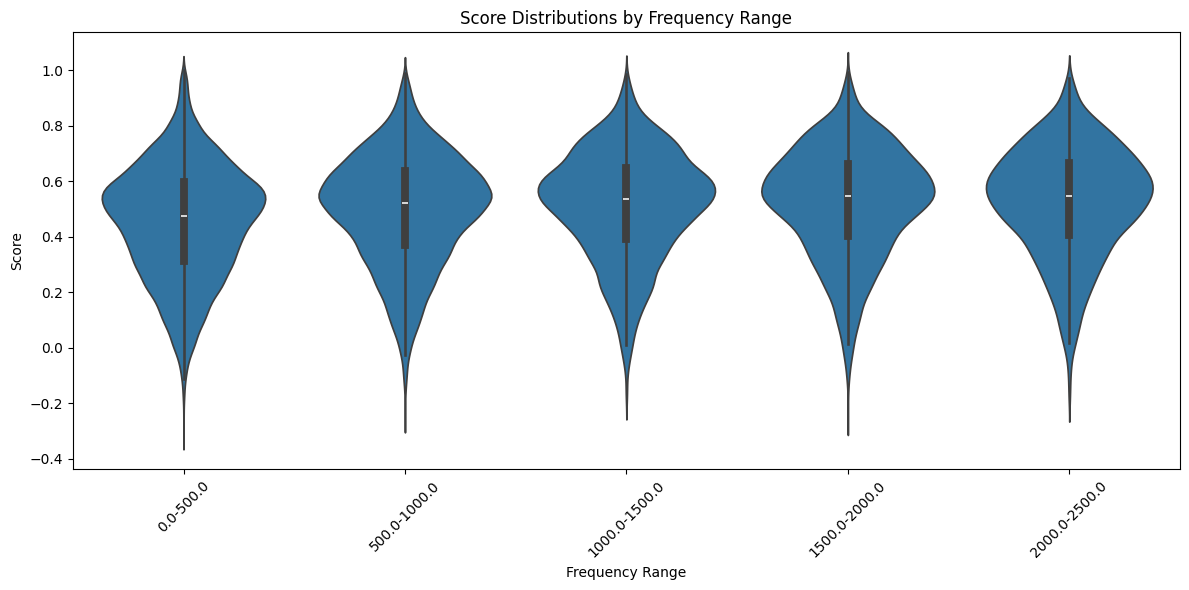

In [58]:
plot_score_distributions(frequency_scores, num_freq_buckets=5, max_freq=2500)

In [84]:
# how many names have a frequency above 500
min_freq = 500
high_freq_names = [name for name, freq in name_frequency.items() if freq > min_freq]
print(len(high_freq_names))
print(len([name for name in high_freq_names if name in swivel_vocab]))
print(len([name for name in high_freq_names if name in name_buckets]))

68180
67227
55573


In [63]:
# how many names have a frequency above 1000
min_freq = 1000
high_freq_names = [name for name, freq in name_frequency.items() if freq > min_freq]
print(len(high_freq_names))
print(len([name for name in high_freq_names if name in swivel_vocab]))
print(len([name for name in high_freq_names if name in name_buckets]))

43636
43402
40028


In [64]:
print([name for name in high_freq_names if name not in swivel_vocab])

['abiff', 'alderfer', 'amundsen', 'ao', 'apgar', 'applegate', 'applewhite', 'ashcraft', 'ashcroft', 'aspinwall', 'au', 'bachelder', 'baldridge', 'blackmer', 'blankenship', 'bondurant', 'brenneman', 'brubaker', 'brumbaugh', 'burlingame', 'castleberry', 'churchman', 'contreras', 'corcoran', 'dejarnette', 'dk', 'drinkwater', 'es', 'fairweather', 'grandma', 'gwaltney', 'hagerman', 'hardcastle', 'higginbotham', 'is', 'kuykendall', 'lauderdale', 'leatherman', 'leavenworth', 'macomber', 'maldonado', 'mcadams', 'mccandless', 'mcclanahan', 'mcilvaine', 'mcmichael', 'mcnamara', 'mcwilliams', 'musselman', 'obituaries', 'ramsdell', 'satterfield', 'schrader', 'shackford', 'showalter', 'snodgrass', 'stackhouse', 'stallings', 'starbuck', 'starkweather', 'stockman', 'swearingen', 'sweetland', 'templeman', 'thweatt', 'timberlake', 'unobtainable', 'wagstaff', 'wanamaker', 'waterbury', 'watkinson', 'weatherford', 'westgate', 'za', 'zabriskie', 'ingebrigtsen', 'ce', 'ie', 'il', 'll', 'nr', 'rt', 'widowed'

In [85]:
min_freq = 500
high_freq_names = [name for name, freq in name_frequency.items() if freq > min_freq and name in swivel_vocab and name in name_buckets]
print(len(high_freq_names))

55271


## Calculate very high frequency names

- min_freq = 10k -> 10k names
- min_freq = 20k -> 6k names
- min_freq = 25k -> 5k names

In [95]:
min_freq = 10000
very_high_freq_names = [name for name, freq in name_frequency.items() if freq > min_freq and name in swivel_vocab and name in name_buckets]
print(len(very_high_freq_names))

9697


In [87]:
print(very_high_freq_names[0:20])

['aaltje', 'aaron', 'abbie', 'abby', 'abe', 'abel', 'abigail', 'abner', 'abraham', 'abram', 'ada', 'adah', 'adaline', 'adam', 'adami', 'adams', 'adamus', 'adda', 'addie', 'addison']


## Calculate for each frequent name, how many other frequent names have a similarity score above a threshold

if min_freq is 1000, there are 177 similar names per high freq name 

if min_freq is 500, there are 239 similar names per high freq name 

In [88]:
threshold = 0.4
num_similars = 0
for name in tqdm(high_freq_names):
    swivel_scores = get_best_swivel_matches(model=swivel_model, 
                                            vocab=swivel_vocab, 
                                            input_names=np.array([name]),
                                            candidate_names=np.array(high_freq_names), 
                                            encoder_model=None,
                                            k=1000, 
                                            batch_size=1000,
                                            add_context=True,
                                            progress_bar=False,
                                            n_jobs=1)
    num_similars += len([name for name, score in swivel_scores[0] if score > threshold])
print(num_similars / len(high_freq_names))

100%|██████████| 55271/55271 [4:05:52<00:00,  3.75it/s]  

239.01830978270704


## Graph frequency of very high frequency names

In [101]:
# create dataframe of frequency
very_high_freq_df = pd.DataFrame([(name_frequency.get(name, 0), math.log10(name_frequency.get(name, 0))) 
                                  for name in very_high_freq_names], columns=['frequency', 'log frequency'])
print(very_high_freq_df.shape)

(9697, 2)


/tmp/ipykernel_891094/2075605439.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


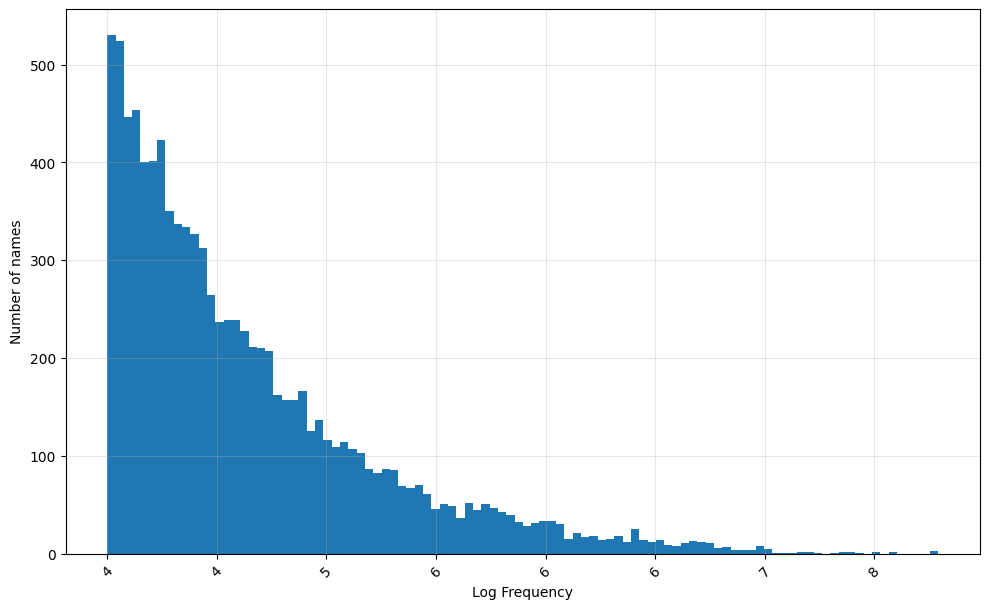

In [103]:
xlabel = 'Log Frequency'
col = 'log frequency'
very_high_freq_df[col].plot(kind='hist', bins=100, figsize=(10, 6), logy=False, grid=True)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
# Add grid for better readability
plt.grid(True, alpha=0.3)
# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.xlabel(xlabel)
plt.ylabel('Number of names')
plt.grid(True, which="both", alpha=0.3)
plt.show()